# Analyzing coffee brewing process
The goal of this project is to find out which factors affect the coffee quality the most.
To that end we wil first build the classifier (with five different classes corresponding to each rating) aiming to predict rating from 1 to 5 based on features data in our dataset.
Then we will find out which features affects the quality of our predictions the most - these will be the factors that affects
the coffee quality mark the most.

Dataset :
coffee_data.csv contains data gathered from cupping sessions which contains such parameters as: 
- brewing time,
- brewing temperature,
- grinding level,
- TDS,
- water pH,
- processing method,
- region and plantation height.

Each coffee was rated from 1-5.

Getting the tools :

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from random import randrange
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from plot_hyperparameters_effects import *
np.random.seed(0)


coffee=pd.read_csv(r'coffee_data.csv')

# inspecting the df

In [6]:
coffee.head()

,region,brewing_temp,coffee_amount,preinfusion,grinding_level,TDS,water_ph,plantation_height,processing_method,brewing_time,mark
0,Panama,91.1,NaN,0.0,7.0,NaN,6.67,1710.0,Honey,189.0,3
1,Panama,94.0,5.9,NaN,2.0,0.14,3.00,1530.0,Honey,95.0,3
2,Colombia,91.6,7.0,0.0,4.0,0.13,5.51,1370.0,Honey,147.0,3
3,Rwanda,92.3,NaN,0.0,4.0,0.13,7.11,1630.0,Honey,158.0,3
4,Panama,98.9,9.5,NaN,3.0,0.11,6.06,1400.0,Washed,178.0,3


In [7]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
region               500 non-null object
brewing_temp         500 non-null float64
coffee_amount        434 non-null float64
preinfusion          436 non-null float64
grinding_level       500 non-null float64
TDS                  401 non-null float64
water_ph             500 non-null float64
plantation_height    500 non-null float64
processing_method    500 non-null object
brewing_time         500 non-null float64
mark                 500 non-null int64
dtypes: float64(8), int64(1), object(2)
memory usage: 39.1+ KB


# imputing missing values

In [8]:
coffee.isnull().sum()

region                0
brewing_temp          0
coffee_amount        66
preinfusion          64
grinding_level        0
TDS                  99
water_ph              0
plantation_height     0
processing_method     0
brewing_time          0
mark                  0
dtype: int64

In [9]:
coffee.TDS.describe()

count    401.000000
mean       0.119152
std        0.022700
min        0.050000
25%        0.100000
50%        0.120000
75%        0.130000
max        0.200000
Name: TDS, dtype: float64

In [10]:
impute_tds=coffee['TDS'].median()
coffee['TDS']=coffee['TDS'].fillna(impute_tds)

In [11]:
coffee.coffee_amount.describe()

count    434.000000
mean       6.988710
std        1.068264
min        3.000000
25%        6.200000
50%        6.900000
75%        7.800000
max       10.000000
Name: coffee_amount, dtype: float64

In [12]:
impute_amount=coffee.coffee_amount.median()
coffee['coffee_amount']=coffee['coffee_amount'].fillna(impute_amount)

In [13]:
coffee.preinfusion.describe()

count    436.000000
mean       0.607798
std        0.488802
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: preinfusion, dtype: float64

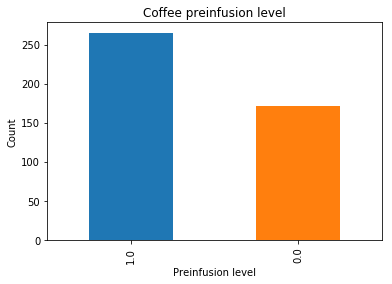

In [14]:
coffee.preinfusion.value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Preinfusion level')
plt.title('Coffee preinfusion level')
plt.show()

In [15]:
coffee['preinfusion']=coffee['preinfusion'].apply(lambda x:'unknown' if ((x!=0) & (x!=1)) else x)

In [16]:
coffee.isnull().sum()

region               0
brewing_temp         0
coffee_amount        0
preinfusion          0
grinding_level       0
TDS                  0
water_ph             0
plantation_height    0
processing_method    0
brewing_time         0
mark                 0
dtype: int64

# Looking at the distribution of labels

In [17]:
coffee.mark.value_counts()

3    149
5    100
4    100
2     99
1     52
Name: mark, dtype: int64

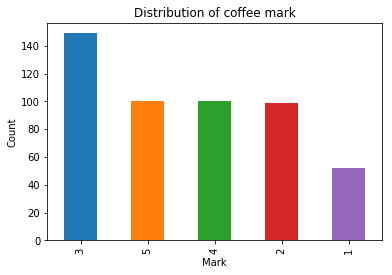

In [18]:
coffee.mark.value_counts().plot(kind='bar')
plt.title('Distribution of coffee mark')
plt.xlabel('Mark')
plt.ylabel('Count')
plt.show()

The dataset is relatively well balanced.

# Examining features data

In [19]:
coffee.columns

Index(['region', 'brewing_temp', 'coffee_amount', 'preinfusion',
       'grinding_level', 'TDS', 'water_ph', 'plantation_height',
       'processing_method', 'brewing_time', 'mark'],
      dtype='object')

In [20]:
for c in coffee.columns:
    print(c,' : ',coffee[c].unique()[:25])

region  :  ['Panama' 'Colombia' 'Rwanda' 'Kenya' 'Ethiopia' 'Honduras' 'Brazil'
 'Guatemala']
brewing_temp  :  [91.1 94.  91.6 92.3 98.9 88.9 88.8 85.2 92.8 92.  95.9 89.6 83.5 95.2
 87.8 93.5 91.3 92.4 92.5 90.3 92.2 97.1 89.5 95.3 93.2]
coffee_amount  :  [6.9 5.9 7.  9.5 8.3 8.6 6.3 6.  7.1 8.4 7.8 6.4 8.1 6.8 6.7 8.  5.3 7.3
 4.5 6.1 7.5 9.2 5.7 5.4 7.2]
preinfusion  :  [0.0 'unknown' 1.0]
grinding_level  :  [7. 2. 4. 3. 5. 6. 1. 8. 9.]
TDS  :  [0.12 0.14 0.13 0.11 0.15 0.09 0.1  0.16 0.08 0.06 0.07 0.17 0.2  0.05]
water_ph  :  [6.67 3.   5.51 7.11 6.06 8.93 5.12 3.99 5.73 6.29 5.48 4.14 3.84 3.64
 6.62 5.68 6.37 5.65 6.75 5.96 3.5  5.07 8.02 6.14 8.54]
plantation_height  :  [1710. 1530. 1370. 1630. 1400. 1540. 1470. 1080. 1780. 1060. 1300. 1390.
 1410. 1360. 1950. 1580. 1260. 1660. 1520. 1590. 1350. 1330. 1670. 1980.
 1720.]
processing_method  :  ['Honey' 'Washed' 'Natural' 'Pulped Natural']
brewing_time  :  [189.  95. 147. 158. 178. 169. 166. 119. 151. 142. 197. 118. 195. 146.
 21

Which features are categorical ?

In [21]:
cat_features=['region','processing_method','preinfusion']

Which features are continuous ?

In [22]:
continuous_features=[col for col in coffee.columns if \
                  (col not in cat_features) & (col not in ['mark','grinding_level'])]

discrete features :

In [23]:
discrete_features=['grinding_level']

# descriptive statistics

summary statistics for the entire dataset :

In [24]:
coffee[continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,91.39,6.98,0.12,6.30,1405.80,164.84
std,2.90,1.00,0.02,1.34,222.31,33.55
min,83.00,3.00,0.05,3.00,700.00,60.00
25%,89.30,6.30,0.11,5.40,1250.00,139.75
50%,91.30,6.90,0.12,6.28,1400.00,166.00
75%,93.40,7.70,0.13,7.24,1550.00,191.00
max,100.00,10.00,0.20,10.00,2000.00,240.00


summary statistics for the lowest rated coffee :

In [25]:
coffee[coffee.mark==1][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,52.00,52.00,52.00,52.00,52.00,52.00
mean,91.38,6.47,0.12,6.02,1396.92,192.38
std,3.00,0.55,0.02,1.31,186.27,18.21
min,83.40,4.90,0.08,3.44,1070.00,153.00
25%,89.75,6.10,0.11,5.14,1257.50,178.75
50%,91.70,6.60,0.12,5.86,1380.00,192.00
75%,93.43,6.90,0.14,7.03,1525.00,203.75
max,97.10,7.50,0.20,8.65,1800.00,237.00


summary statistics for the highest rated coffee :

In [26]:
coffee[coffee.mark==5][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,100.00,100.00,100.00,100.00,100.00,100.00
mean,91.28,7.10,0.12,6.37,1446.70,169.06
std,2.89,1.01,0.02,1.18,240.58,37.00
min,85.20,4.80,0.08,3.16,900.00,60.00
25%,88.90,6.40,0.11,5.65,1277.50,142.75
50%,90.95,7.00,0.12,6.44,1430.00,172.50
75%,93.32,8.00,0.13,7.25,1590.00,196.75
max,99.30,9.20,0.16,8.93,1970.00,234.00


When we compare coffee of rating 1 with coffee rated 5 we can observe that:
1. On average, better coffee has higher coffee amount
2. The water ph is higher in better coffee
3. Plantation height is greater in coffee rated 5
4. Coffee rated 5 has shorter brewing time than coffee rated 1

The same 4 observations holds true when we compare general coffee with coffee of rating 5,
however the differences are less pronounced.

Let's compare coffee rated 3 with the general coffee (coffee of all ratings)

In [27]:
coffee[coffee.mark==3][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,149.00,149.00,149.00,149.00,149.00,149.00
mean,93.87,7.17,0.12,6.41,1415.23,165.57
std,2.06,1.15,0.02,1.30,204.15,36.33
min,87.20,4.50,0.05,3.00,750.00,67.00
25%,92.50,6.30,0.11,5.45,1270.00,138.00
50%,93.80,7.20,0.12,6.37,1420.00,170.00
75%,95.40,8.00,0.13,7.39,1570.00,191.00
max,100.00,10.00,0.16,9.32,1990.00,236.00


In [28]:
coffee[continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,91.39,6.98,0.12,6.30,1405.80,164.84
std,2.90,1.00,0.02,1.34,222.31,33.55
min,83.00,3.00,0.05,3.00,700.00,60.00
25%,89.30,6.30,0.11,5.40,1250.00,139.75
50%,91.30,6.90,0.12,6.28,1400.00,166.00
75%,93.40,7.70,0.13,7.24,1550.00,191.00
max,100.00,10.00,0.20,10.00,2000.00,240.00


One can see that coffee rated 3 has :
- above average brewing_temp
- above average coffee_amount
- above average water_ph
- above average plantation_height

coffee rated 4 vs general coffee :

In [29]:
coffee[coffee.mark==4][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,100.00,100.00,100.00,100.00,100.0,100.00
mean,89.49,6.51,0.12,6.32,1368.6,146.24
std,2.04,0.56,0.02,1.51,240.1,16.37
min,83.00,4.60,0.06,3.39,700.0,97.00
25%,88.57,6.10,0.10,5.26,1227.5,135.75
50%,89.60,6.60,0.12,6.22,1380.0,148.00
75%,90.72,6.90,0.13,7.38,1492.5,156.25
max,94.10,8.20,0.20,10.00,2000.0,183.00


Coffee rated 4 has:
- below average brewing_temp
- below average coffee amount
- below average plantation height
- below average brewing_time

Coffee rated 2 vs general coffee :

In [30]:
coffee[continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,91.39,6.98,0.12,6.30,1405.80,164.84
std,2.90,1.00,0.02,1.34,222.31,33.55
min,83.00,3.00,0.05,3.00,700.00,60.00
25%,89.30,6.30,0.11,5.40,1250.00,139.75
50%,91.30,6.90,0.12,6.28,1400.00,166.00
75%,93.40,7.70,0.13,7.24,1550.00,191.00
max,100.00,10.00,0.20,10.00,2000.00,240.00


In [31]:
coffee[coffee.mark==2][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,99.00,99.00,99.00,99.00,99.00,99.0
mean,89.68,7.31,0.12,6.20,1392.53,163.8
std,1.71,1.02,0.02,1.41,224.63,33.7
min,85.50,3.00,0.06,3.25,850.00,85.0
25%,88.65,6.80,0.11,5.26,1240.00,135.5
50%,89.80,7.20,0.12,6.14,1380.00,159.0
75%,90.75,7.90,0.13,7.06,1540.00,189.5
max,94.60,9.30,0.17,9.22,1980.00,240.0


Coffee rated 2 has :
- below average brewing_temp
- above average coffee_amount
- below average plantation_height

coffee rated 1 vs general coffee

In [32]:
coffee[continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,91.39,6.98,0.12,6.30,1405.80,164.84
std,2.90,1.00,0.02,1.34,222.31,33.55
min,83.00,3.00,0.05,3.00,700.00,60.00
25%,89.30,6.30,0.11,5.40,1250.00,139.75
50%,91.30,6.90,0.12,6.28,1400.00,166.00
75%,93.40,7.70,0.13,7.24,1550.00,191.00
max,100.00,10.00,0.20,10.00,2000.00,240.00


In [33]:
coffee[coffee.mark==1][continuous_features].describe().round(2)

,brewing_temp,coffee_amount,TDS,water_ph,plantation_height,brewing_time
count,52.00,52.00,52.00,52.00,52.00,52.00
mean,91.38,6.47,0.12,6.02,1396.92,192.38
std,3.00,0.55,0.02,1.31,186.27,18.21
min,83.40,4.90,0.08,3.44,1070.00,153.00
25%,89.75,6.10,0.11,5.14,1257.50,178.75
50%,91.70,6.60,0.12,5.86,1380.00,192.00
75%,93.43,6.90,0.14,7.03,1525.00,203.75
max,97.10,7.50,0.20,8.65,1800.00,237.00


Coffee rated 1 can be characterized by:
- below average coffee amount
- below average plantation height
- above average brewing time

# How does the continuous features vary with the response variable ?

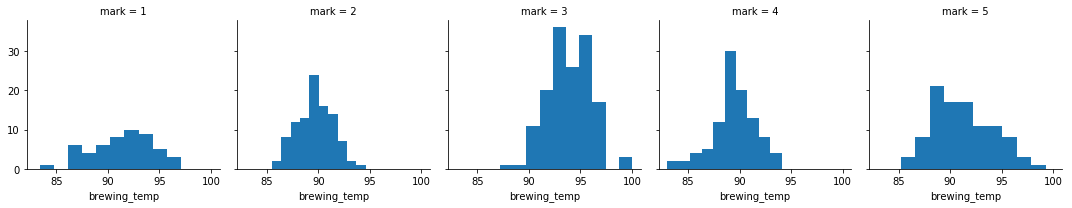

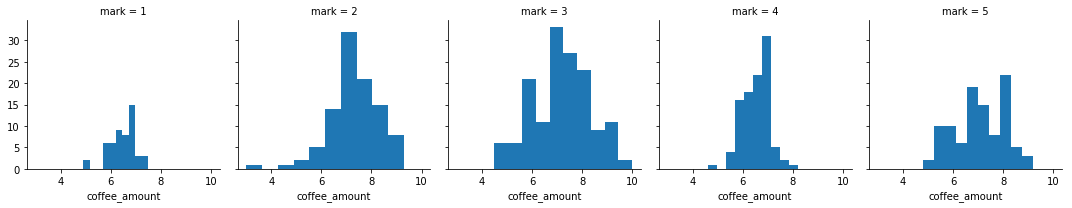

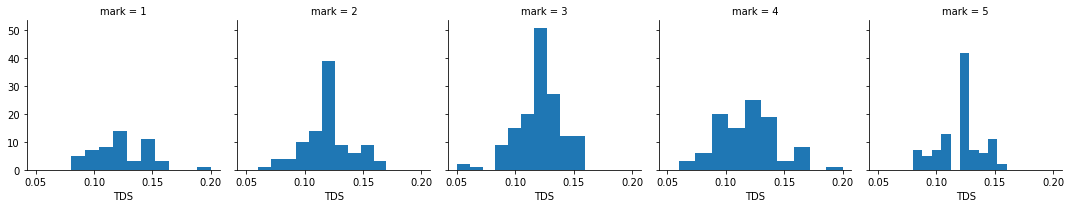

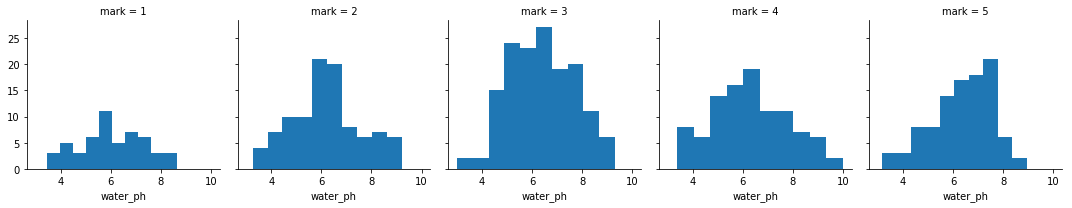

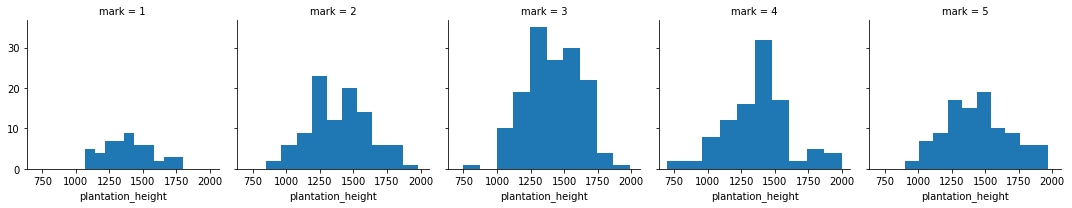

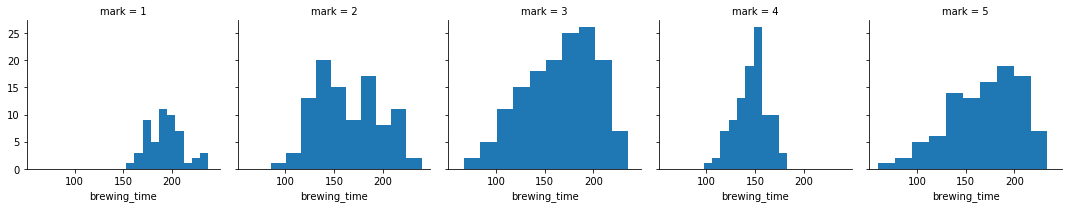

In [34]:
for cf in continuous_features:
  g = sns.FacetGrid(coffee, col='mark')
  g.map(plt.hist, cf)
  plt.show()
  

# Looking at the distribution of categorical features

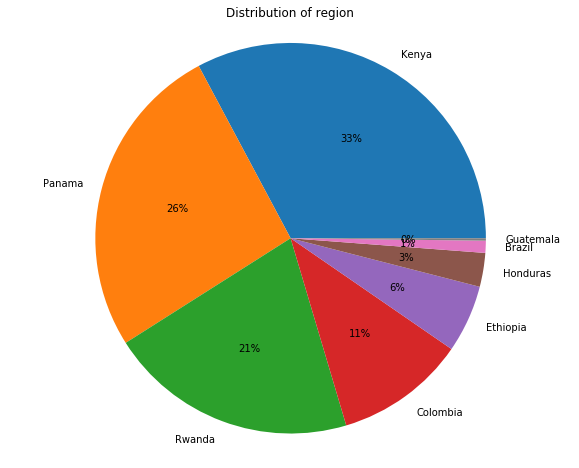

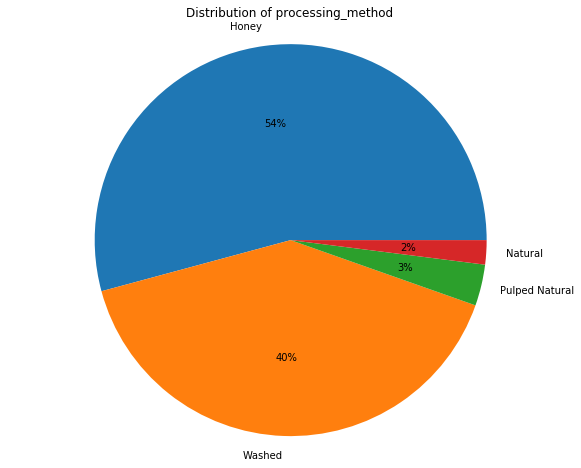

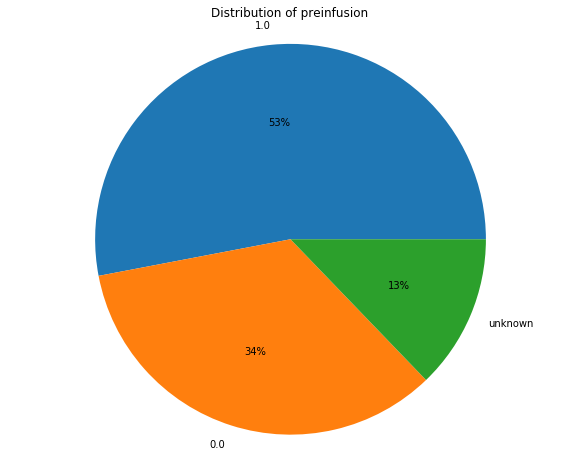

In [35]:
for ct in cat_features:
    plt.figure(figsize=(10,8))
    coffee[ct].value_counts().plot.pie(autopct='%1.0f%%')
    plt.title('Distribution of {}'.format(ct))
    plt.ylabel('')
    plt.axis('equal')
    plt.show()
    print()

How do categorical features vary with the response variable ?

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


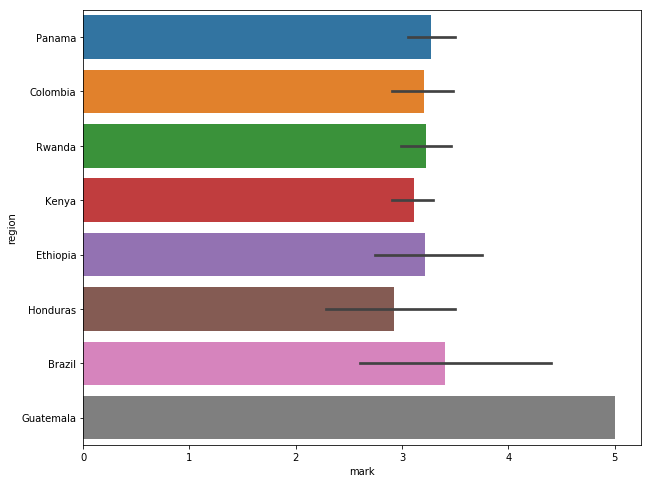

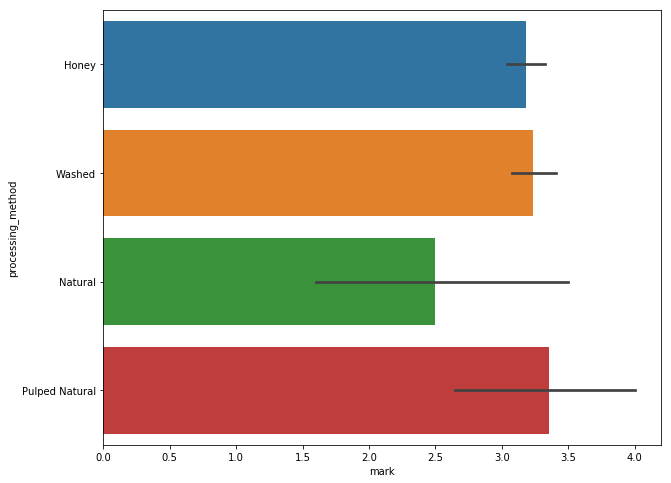

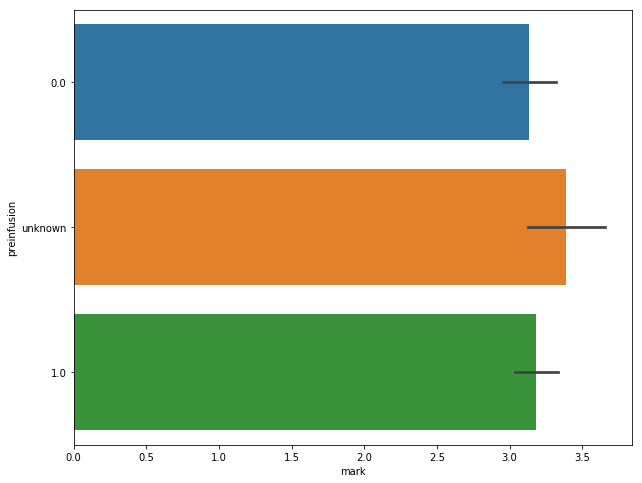

In [36]:
for ct in cat_features:
    plt.figure(figsize=(10,8))
    sns.barplot(x='mark',y=ct,data=coffee)
    plt.show()
    print()

We can see that all processing methods, except for 'Natural',yield the same mark on average.

How does the variable grinding level vary with the response variable mark ?

/usr/lib/python3/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


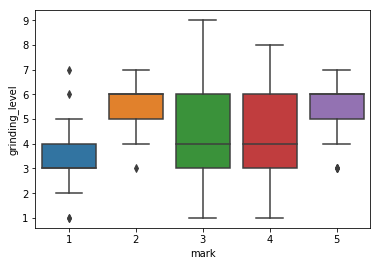

In [37]:
sns.boxplot(x='mark',y='grinding_level',data=coffee)
plt.show()

# Conclusions from Empirical Data Analysis
In our EDA we have found that :

Regarding coffee rated 5 :
- On average, coffee rated 5 has higher coffee amount than coffee rated 1
- The water ph in coffe rated 5 is higher than in coffee rated 1
- Plantation height in coffee rated 5 is greater than in coffee rated 1
- Coffee rated 5 has shorter brewing time than coffee rated 1

To the lesser extent the same 4 observations holds true when we compare general coffee with coffee of rating 5.

Regarding coffee rated 4 :

Coffee rated 4 has:
- below average brewing_temp
- below average coffee amount
- below average plantation height
- below average brewing_time

Regarding coffee rated 3 :

coffee rated 3 has :
- above average brewing_temp
- above average coffee_amount
- above average water_ph
- above average plantation_height

Regarding coffee rated 2 :

Coffee rated 2 has :
- below average brewing_temp
- above average coffee_amount
- below average plantation_height

Regarding coffee rated 1 :

Coffee rated 1 can be characterized by:
- below average coffee amount
- below average plantation height
- above average brewing time



# encoding categorical data

Procesing methods other than ''Natural" have the same marks on average, hence we will encode "Natural" as 1 end all else as 0.

In [38]:
coffee['natural_processing']=[1 if m=='Natural' else 0 for m in coffee.processing_method]
del coffee['processing_method']

In [39]:
def one_hot_encoder(df_column,what_is_1):
	output=[]
	for row in df_column:
		if row==what_is_1:
			output.append(1)
		else:
			output.append(0)
	return output

def one_hot_caller(df_column,set_of_categories):
	cat_columns_encoded={}
	for thing in set_of_categories:
		cat_columns_encoded[thing]=one_hot_encoder(df_column,thing)
	return cat_columns_encoded

def get_distinct_values_from_column(df_column):
	distinct_df_column=list(set([row for row in df_column]))
	return distinct_df_column

def call_one_hot_caller(df_column):
	distinct=get_distinct_values_from_column(df_column=df_column)
	return one_hot_caller(df_column,distinct)
        
def encode_and_implement_in_df(df,df_column):
    for key,value in call_one_hot_caller(df_column).items():
        df[key]=value
    return df

def encode_implement_all(df,list_of_columns_to_encode):
    '''
    Returns a dataframe with categorical variables encoded as binary variables
    
    '''
    
    '''
    Parameters
    
    The functions takes as arguments the df
    and a list of df columns (pandas series) to encode
    
    '''
    for column in list_of_columns_to_encode:
        encode_and_implement_in_df(df,column)
    for i in list_of_columns_to_encode:
        try :
            del df[str(i.name)]
        
        except Exception:
            pass
    
    return df

In [40]:
names_of_columns_to_encode=['region','preinfusion']

In [41]:
df=encode_implement_all(coffee,[coffee[nocte] for nocte in names_of_columns_to_encode])

In [42]:
df.head()

,brewing_temp,coffee_amount,grinding_level,TDS,water_ph,plantation_height,brewing_time,mark,natural_processing,Panama,Kenya,Ethiopia,Guatemala,Rwanda,Honduras,Colombia,Brazil,0.0,1.0,unknown
0,91.1,6.9,7.0,0.12,6.67,1710.0,189.0,3,0,1,0,0,0,0,0,0,0,1,0,0
1,94.0,5.9,2.0,0.14,3.00,1530.0,95.0,3,0,1,0,0,0,0,0,0,0,0,0,1
2,91.6,7.0,4.0,0.13,5.51,1370.0,147.0,3,0,0,0,0,0,0,0,1,0,1,0,0
3,92.3,6.9,4.0,0.13,7.11,1630.0,158.0,3,0,0,0,0,0,1,0,0,0,1,0,0
4,98.9,9.5,3.0,0.11,6.06,1400.0,178.0,3,0,1,0,0,0,0,0,0,0,0,0,1


Categorizing countries :

In [43]:
df['south_america']=[1 if (g+b+p+h+c)>0 else 0 for g,b,p,h,c in zip(df.Guatemala,df.Brazil,df.Panama,df.Honduras,df.Colombia)]
df['africa']=[1 if (k+e+r)>0 else 0 for k,e,r in zip(df.Kenya,df.Ethiopia,df.Rwanda)]
df['other_countries']=[1 if (e+h+b+g)>0 else 0 for e,h,b,g in zip(df.Ethiopia,df.Honduras,df.Brazil,df.Guatemala)]
underrepresented_countries=['Ethiopia','Honduras','Brazil','Guatemala']
for uc in underrepresented_countries:
  try:
    del df[uc]
  except Exception:
    pass

Creating additional features based on insights from EDA :

In [44]:
# creating feature 'above_avg_coffee_amount'
mean_coffee=df.coffee_amount.mean()
above_avg_coffee_amount=[1 if v>mean_coffee else 0 for v in df.coffee_amount]
df['above_avg_coffee_amount']=above_avg_coffee_amount

# creating feature 'above_avg_water_ph'
mean_ph=df.water_ph.mean()
above_avg_water_ph=[1 if v>mean_ph else 0 for v in df.water_ph]
df['above_avg_water_ph']=above_avg_water_ph

# creating feature 'above_avg_plantation_height'
mean_height=df.plantation_height.mean()
above_avg_pantation_height=[1 if v>mean_height else 0 for v in df.plantation_height]
df['above_avg_pantation_height']=above_avg_pantation_height

# creating feature 'below_avg_brewing_time'
mean_time=df.brewing_time.mean()
below_avg_brewing_time=[1 if v<mean_time else 0 for v in df.brewing_time]
df['below_avg_brewing_time']=below_avg_brewing_time

# creating feature 'above_avg_brewing_temp'
mean_temp=df.brewing_temp.mean()
above_avg_brewing_temp=[1 if v<mean_temp else 0 for v in df.brewing_temp]
df['above_avg_brewing_temp']=above_avg_brewing_temp

# creating feature 'more_coffee_than_lowest_rating'
mean_amount_worst=df[df.mark==1].coffee_amount.mean()
more_coffee_than_lowest_rating=[1 if v>mean_amount_worst else 0 for v in df.coffee_amount]
df['more_coffee_than_lowest_rating']=more_coffee_than_lowest_rating

# creating feature 'higher_ph_than_lowest_rating'
mean_ph_worst=df[df.mark==1].water_ph.mean()
higher_ph_than_lowest_rating=[1 if v>mean_ph_worst else 0 for v in df.water_ph]
df['higher_ph_than_lowest_rating']=higher_ph_than_lowest_rating

# creating feature 'greater_elevation_than_lowest_rating'
mean_height_worst=df[df.mark==1].plantation_height.mean()
greater_elevation_than_lowest_rating=[1 if v>mean_height_worst else 0 for v in df.plantation_height]
df['greater_elevation_than_lowest_rating']=greater_elevation_than_lowest_rating

# creating feature 'shorter_brewing_time_than_lowest_rating'
mean_time_worst=df[df.mark==1].brewing_time.mean()
shorter_brewing_time_than_lowest_rating=[1 if v<mean_time_worst else 0 for v in df.brewing_time]
df['shorter_brewing_time_than_lowest_rating']=shorter_brewing_time_than_lowest_rating

In [45]:
df.head()

,brewing_temp,coffee_amount,grinding_level,TDS,water_ph,plantation_height,brewing_time,mark,natural_processing,Panama,...,other_countries,above_avg_coffee_amount,above_avg_water_ph,above_avg_pantation_height,below_avg_brewing_time,above_avg_brewing_temp,more_coffee_than_lowest_rating,higher_ph_than_lowest_rating,greater_elevation_than_lowest_rating,shorter_brewing_time_than_lowest_rating
0,91.1,6.9,7.0,0.12,6.67,1710.0,189.0,3,0,1,...,0,0,1,1,0,1,1,1,1,1
1,94.0,5.9,2.0,0.14,3.00,1530.0,95.0,3,0,1,...,0,0,0,1,1,0,0,0,1,1
2,91.6,7.0,4.0,0.13,5.51,1370.0,147.0,3,0,0,...,0,1,0,0,1,0,1,0,0,1
3,92.3,6.9,4.0,0.13,7.11,1630.0,158.0,3,0,0,...,0,0,1,1,1,0,1,1,1,1
4,98.9,9.5,3.0,0.11,6.06,1400.0,178.0,3,0,1,...,0,1,0,0,0,0,1,1,1,1


# Splitting the data into train,validation and test set

In [46]:
def train_val_test_split(df,frac_train,frac_val):
  '''
  Returns 3 dataframes corresponding to train,validation and test set
  
  '''
  
  '''
  Parameters :
  df - dataset in pandas DataFrame format,
  frac_train - float between 0 and 1, e.g. 0.6
  frac_val - float between 0 and 1, e.g. 0.2
   
  '''
  
  original_length = len(df)
  train_set = df.sample(frac = frac_train)
  df = df.drop(train_set.index)
  frac_val = frac_val * original_length / len(df)
  validation_set = df.sample(frac = frac_val)
  df = df.drop(validation_set.index)
  percent_test = 1 - frac_train-frac_val
  test_set = df

  return train_set, validation_set, test_set
  
    

In [47]:
X_train,X_val,X_test=train_val_test_split(df,0.6,0.2)

In [48]:
y_train=pd.DataFrame(X_train['mark'],columns=['mark'])
del X_train['mark']

In [49]:
y_val=pd.DataFrame(X_val['mark'],columns=['mark'])
del X_val['mark']

In [50]:
y_test=pd.DataFrame(X_test['mark'],columns=['mark'])
del X_test['mark']

In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Making predictions with Random Forest

In [52]:
np.random.seed(0)

rf = RandomForestClassifier(random_state = 123)
rf.fit(X_train,y_train.values.ravel())
predictions = rf.predict(X_val)
parapredictions = rf.predict(X_train)
vacc = accuracy_score(predictions,y_val)
tracc = accuracy_score(parapredictions,y_train)
print('Train accuracy is {} whereas validation set accuracy is {}'.format(tracc,vacc))

Train accuracy is 0.98 whereas validation set accuracy is 0.69


The model is clearly overfitting. Let's see how the amount of data affects the difference between training and validation accuracy by plotting learning curves.

In [53]:
def plot_learning_curves(algorithm_str,X_train,y_train,X_val,y_val,increment):
	
	model=eval(algorithm_str)

	train_accuracies=[]
	validation_accuracies=[]
	observations=list(range(0,len(X_train),increment))
	
	
	for i in range(1,len(X_train),increment):
		model.fit(X_train.iloc[:i,:],y_train.iloc[:i].values.ravel())
		predictions=model.predict(X_train.iloc[:i,:])
		accuracy=accuracy_score(y_train.iloc[:i].values.ravel(),predictions)
		train_accuracies.append(accuracy)
		validation_preds=model.predict(X_val)
		val_accuracy=accuracy_score(y_val.values.ravel(),validation_preds)
		validation_accuracies.append(val_accuracy)

	num_observations=len(X_train)
	
	df=pd.DataFrame()
	df['observations']=observations
	df['train_accuracy']=train_accuracies
	df['validation_accuracy']=validation_accuracies
	ax=df.plot(x='observations',figsize=(12,9),grid=True,xticks=[xt for xt in range(1,num_observations,increment)]\
             ,yticks=[yt/10 for yt in range(1,11)])
	ax.legend(loc='lower right')
	plt.title('train accuracy vs validation accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('number of observations in training data')
	plt.show()

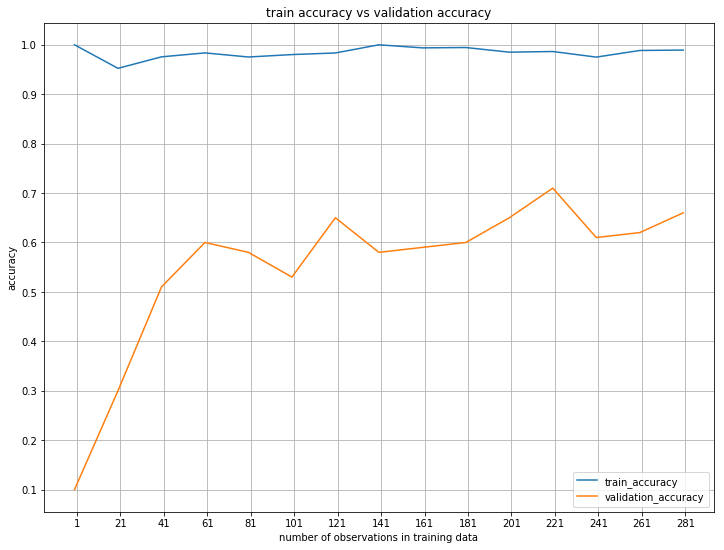

In [54]:
np.random.seed(0)

plot_learning_curves('RandomForestClassifier(random_state = 123)',X_train,y_train,X_val,y_val,20)

# Adressing overfitting

We will plot the effect of changing each hyperparameter on the train and validation accuracy.
That would enable us to narrow down the range of values to search through when looking for the best parameters of a model.

In [61]:
max_leaf_nodes_values = [mln for mln in range(2,31)]
min_samples_leaf_values = [msl for msl in range(2,101)]
max_features_values = [mf for mf in range(2,28)]
min_samples_split_values = [mss for mss in range(2,101)]
n_estimators_values = [ne * 10 for ne in range(1,36)]

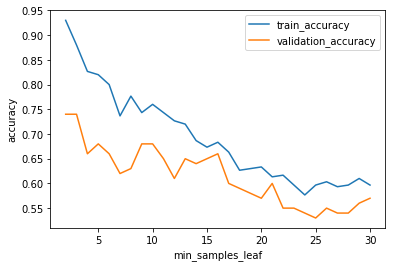

In [62]:
plot_hyperparameters_effects('RandomForestClassifier(random_state=123,)',X_train,y_train,X_val,y_val,\
                             'max_leaf_nodes','min_samples_leaf',\
                            max_leaf_nodes_values,min_samples_leaf_values)

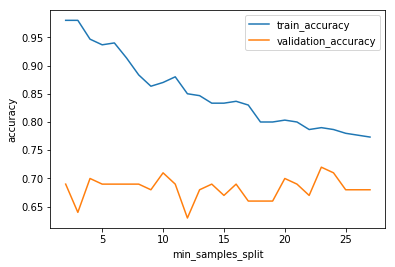

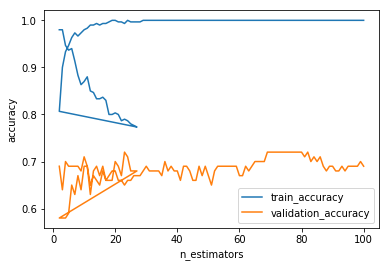

In [63]:
plot_hyperparameters_effects('RandomForestClassifier(random_state=123,)',X_train,y_train,X_val,y_val,\
                             'max_features','min_samples_split','n_estimators',\
                             max_features_values,min_samples_split_values,n_estimators_values)
                             

In [0]:
grid = {'n_estimators':[n for n in range(1,351)],
        'min_samples_split':[2]
        ,'min_samples_leaf':[2]
        ,'max_leaf_nodes':[25],
        'max_features':[9]}

In [0]:
np.random.seed(0)

from sklearn.model_selection import ParameterGrid

rfc=RandomForestClassifier(random_state=123)

validation_accuracies=[]

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfc.set_params(**g)  # ** is "unpacking" the dictionary
    rfc.fit(X_train,y_train.values.ravel())
    predictions=rfc.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val,predictions))
    

# Find best hyperparameters
best_idx = np.argmax(validation_accuracies)
print('The best model is : ',ParameterGrid(grid)[best_idx],"It's accuracy is : ",validation_accuracies[best_idx])

The best model is :  {'n_estimators': 114, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 25, 'max_features': 9} It's accuracy is :  0.75


In [0]:
np.random.seed(0)

optimal_model = RandomForestClassifier(random_state=123,n_estimators = 114,min_samples_split = 2,min_samples_leaf = 2,max_leaf_nodes = 25,max_features = 9)
optimal_model.fit(X_train,y_train.values.ravel())
prophecies = optimal_model.predict(X_test)
train_preds = optimal_model.predict(X_train)
test_acc = accuracy_score(y_test,prophecies)
train_acc = accuracy_score(y_train,train_preds)
print('Train accuracy is {} whereas test accuracy is {}'.format(train_acc,test_acc))

Train accuracy is 0.8766666666666667 whereas test accuracy is 0.71


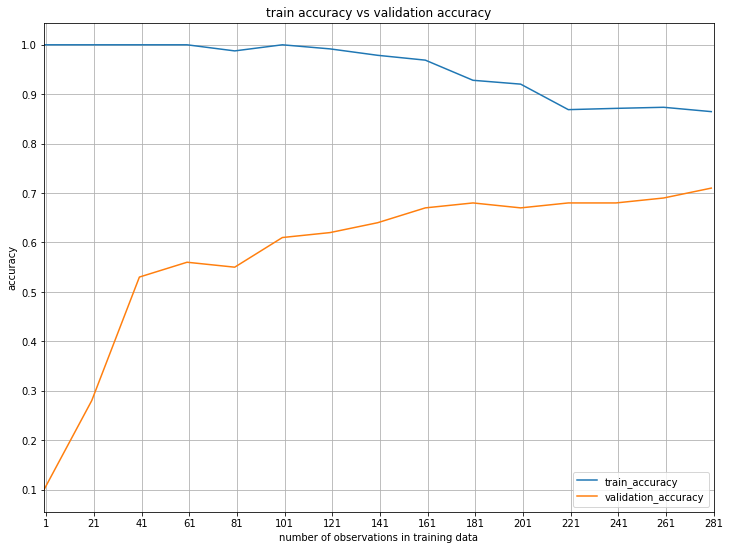

In [0]:
plot_learning_curves('RandomForestClassifier(random_state=123,n_estimators = 114,min_samples_split = 2,min_samples_leaf = 2,max_leaf_nodes = 25,max_features = 9)',X_train,y_train,X_val,y_val,20)

From the chart above we can suspect that with more data we could farther alleviate the overfitting problem.
To get that data,we can split the data into 80 % train and 20 % test set. Then we can use out-of-bag score to validate our model on the train set. This way, we will be using 80 % of the data instead of 60 %, while maintaing the ability to reliably measure the generalization error.

In [0]:
from sklearn.model_selection import train_test_split

y = df['mark']
del df['mark']
X = df

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train_2.head()

,brewing_temp,coffee_amount,grinding_level,TDS,water_ph,plantation_height,brewing_time,natural_processing,Colombia,Kenya,Panama,Rwanda,0.0,1.0,unknown,south_america,africa,other_countries,above_avg_coffee_amount,above_avg_water_ph,above_avg_pantation_height,below_avg_brewing_time,above_avg_brewing_temp,more_coffee_than_lowest_rating,higher_ph_than_lowest_rating,greater_elevation_than_lowest_rating,shorter_brewing_time_than_lowest_rating
249,90.6,6.9,4.0,0.10,9.03,1790.0,156.0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
433,89.4,6.9,1.0,0.12,4.41,1240.0,114.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,1
19,92.5,8.1,4.0,0.08,5.96,1520.0,128.0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,1,1
322,91.7,6.9,2.0,0.12,4.42,1180.0,174.0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1
332,90.9,7.0,3.0,0.12,7.40,1130.0,174.0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,1,0,1


In [0]:
param_to_test = {'n_estimators':[83],
        'min_samples_split':[2]
        ,'min_samples_leaf':[2]
        ,'max_leaf_nodes':[29],
        'max_features':[f for f in range(1,28)]}

In [0]:
np.random.seed(0)

from sklearn.model_selection import ParameterGrid


# Finding the parameters of a model with more data

forest=RandomForestClassifier(random_state=123,oob_score=True)

oob_scores=[]

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(param_to_test):
    forest.set_params(**g)  # ** is "unpacking" the dictionary
    forest.fit(X_train_2,y_train_2.values.ravel())
    oob_scores.append(forest.oob_score_)
    

# Find best hyperparameters
best_idx = np.argmax(oob_scores)
print('The best model is : ',ParameterGrid(param_to_test)[best_idx],"It's out-of-bag accuracy is : ",oob_scores[best_idx])

The best model is :  {'n_estimators': 83, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 29, 'max_features': 16} It's out-of-bag accuracy is :  0.74


In [0]:
np.random.seed(0)

more_data = RandomForestClassifier(random_state=123,n_estimators = 83, min_samples_split = 2, min_samples_leaf = 2, max_leaf_nodes = 29, max_features = 16)
more_data.fit(X_train_2,y_train_2.values.ravel())
forecast = more_data.predict(X_test_2)
paraforecast = more_data.predict(X_train_2)
acc = accuracy_score(y_test_2,forecast)
paraacc = accuracy_score(y_train_2,paraforecast)
print('Train accuracy is {} wheras test accuracy is {}'.format(paraacc,acc))

Train accuracy is 0.86 wheras test accuracy is 0.74


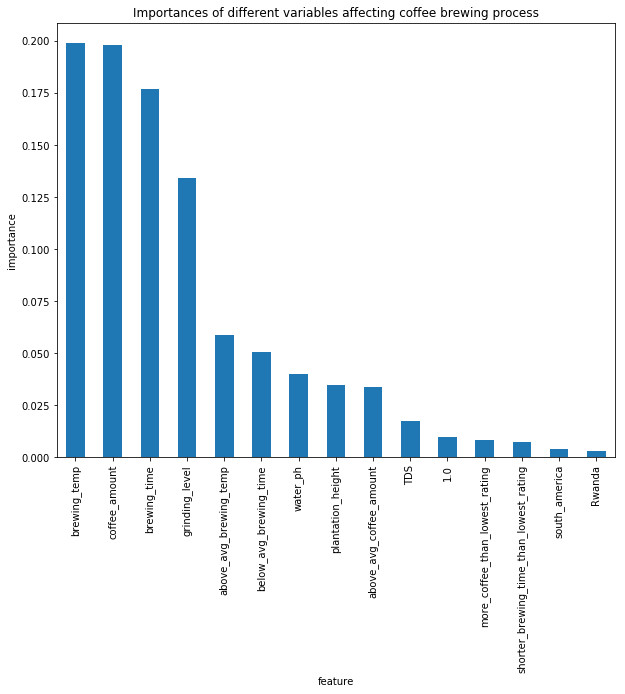

In [0]:
feature_importances = pd.DataFrame(more_data.feature_importances_,
                                   index = X_train_2.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

plt.figure(figsize=(10,8))
feature_importances['importance'].head(15).plot(kind='bar')
plt.ylabel('importance')
plt.xlabel('feature')
plt.title('Importances of different variables affecting coffee brewing process')
plt.show()

# Summing-up

We have identified the most important variables affecting the coffee brewing process as a brewing temperture, coffee amount, brewing time and grinding level.
The best coffee has above average coffee amount, above average water ph and below average brewing time.
Our model classified the ratings of coffee from 1 to 5 with 74 % accuracy.
This 74 % is a fair estimate of the model's ability to generalize, since we didn't commit the comon malpractice of fitting the hyperparameters on the test set.
To put this result into perspective if we would always predict the most common rating 3, we would have achieved only 29.8 % accuracy. Judging from the learning curves, we could further improve model's ability to generalize by collecting more training examples.

